In [1]:
import sys
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
import ariel_load
import tqdm
import copy
import importlib
import ariel_diagnostics
train_data = kgs.load_all_train_data()
kgs.sanity_checks_active = False

local


In [44]:
# FGS = []
# AIRS = []
# N_FGS=2500
# N_AIRS=500
# loaders = ariel_load.default_loaders()
# for d in tqdm.tqdm(train_data):
#     for t in d.transits:
#         tt = copy.deepcopy(t)
#         tt.load_to_step(2, d, loaders)
#         for ii in range(tt.data[0].data.shape[0]//N_FGS):
#             FGS.append(cp.mean(tt.data[0].data[N_FGS*ii:(N_FGS)*(ii+1),...],0).get())
#         for ii in range(tt.data[1].data.shape[0]//N_AIRS):
#             AIRS.append(cp.mean(tt.data[1].data[N_AIRS*ii:(N_AIRS)*(ii+1),...],0).get())
# del tt
# FGS = cp.array(FGS)
# AIRS = cp.array(AIRS)
# data = [FGS, AIRS]
# kgs.dill_save(kgs.temp_dir + '/explore_sensor_modes.pickle', data)
data = kgs.dill_load(kgs.temp_dir + '/explore_sensor_modes.pickle')
print([d.shape for d in data])
#data[0] = data[0][cp.nanmean(data[0],axis=(1,2))<1000,...]
(shp) = (1,32)
#data[1] = data[1][cp.nanmean(data[0],axis=(1,2))<1000,...]
i_wavelength=0
data[1] = data[1][:,:,i_wavelength].reshape(-1,shp[0],shp[1])
print(data[1].shape)
#data[1] = data[1][~cp.any(cp.isnan(data[1]),(1,2)),...]
#print(data[1].shape)

[(32670, 32, 32), (13310, 32, 282)]
(13310, 1, 32)


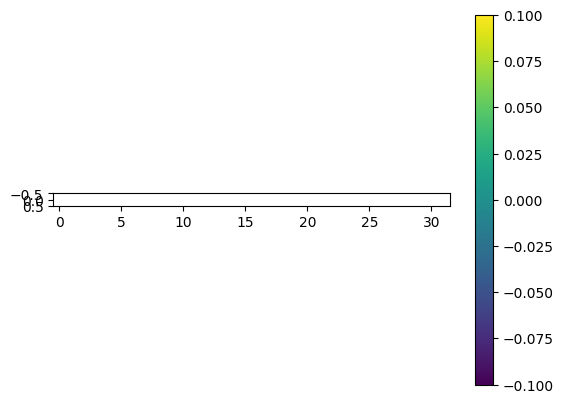

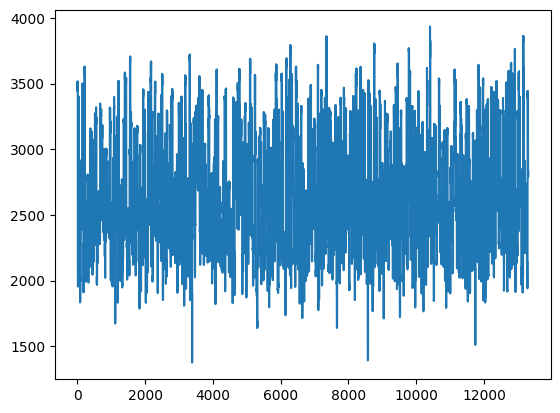

In [45]:

sens_id = 1
#i_wavelength =0
# vals = cp.nanmean(data[sens_id],(1,2))
# print(cp.nanmean(data[sens_id][:, 16,16]))
# inds = cp.argsort(vals)
# data[sens_id][inds[:-len(inds)/20], 16,16]=cp.nan
# print(cp.nanmean(data[sens_id][:, 16,16]))
#data[sens_id] += 0*np.mean(data[sens_id],2)[:,:,None]
plt.figure()
plt.imshow(cp.log(cp.mean(data[sens_id],0)).get())
plt.colorbar()
plt.figure()
plt.plot(cp.nanmean(data[sens_id],axis=(1,2)).get())
#plt.figure()
#plt.plot(cp.nanmean(data[sens_id][:,20:,25:],axis=(1,2)).get())
#cp.argmax(cp.nanmean(data[sens_id][:,20:,25:],axis=(1,2)))


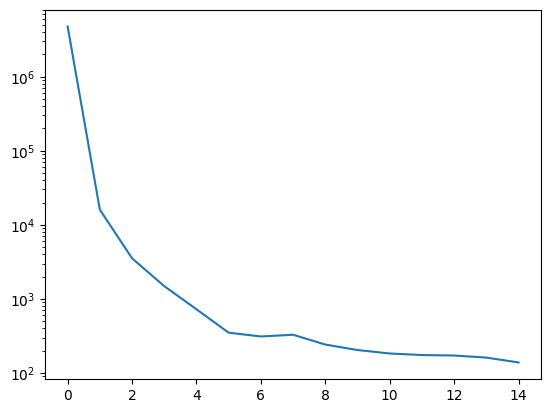

In [46]:
import ariel_numerics
#    weights,components, S = nan_pca(data[sens_id], ii, tol=0.1, verbose=False)
#    print( cp.sqrt(cp.nanmean( (data[sens_id]-cp.tensordot(weights,components,axes=([1], [0])))**2)))
dat = copy.deepcopy(data[sens_id])
SS = []
Sweights = []
Scomponents = []
for ii in range(15):
    weights,components,S = ariel_numerics.nan_pca(dat, 1, tol=1e-1, verbose=False)
    #dat = dat - weights[:,0][:,None,None]*components[0,:][None,:,:]
    dat -= weights[:, [0], None] * components[0]
    SS.append(S.get())
    Sweights.append(weights)
    Scomponents.append(components)
    #plt.figure();plt.semilogy(S.get())
    #weights,components,S = ariel_numerics.nan_pca(data_residual, 4, tol=1e-1, verbose=True)
    #plt.figure();plt.semilogy(S.get())
    #weights,components,S = ariel_numerics.nan_pca(data_residual, 5, tol=1e-1, verbose=True)
plt.figure();plt.semilogy(SS)

7294.965480118231
7294.965480118231


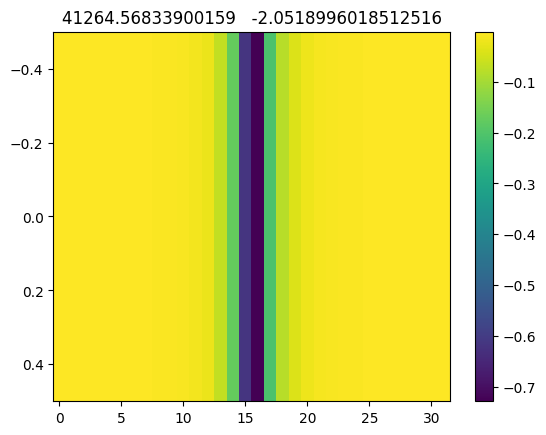

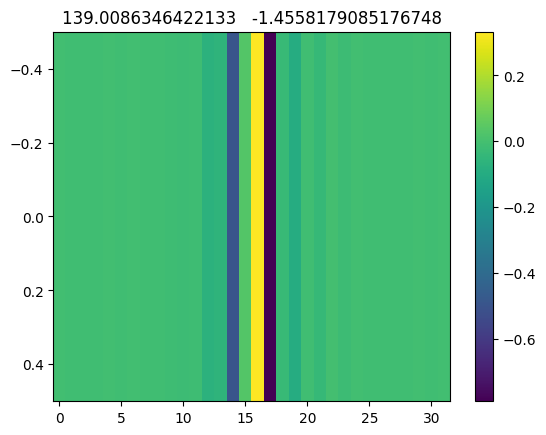

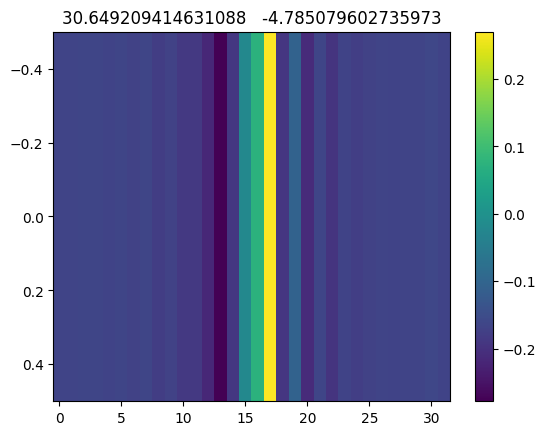

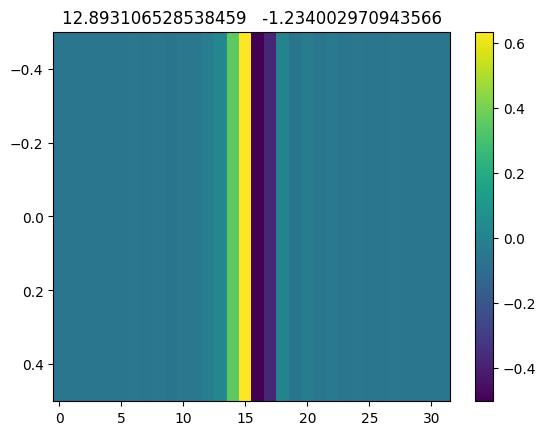

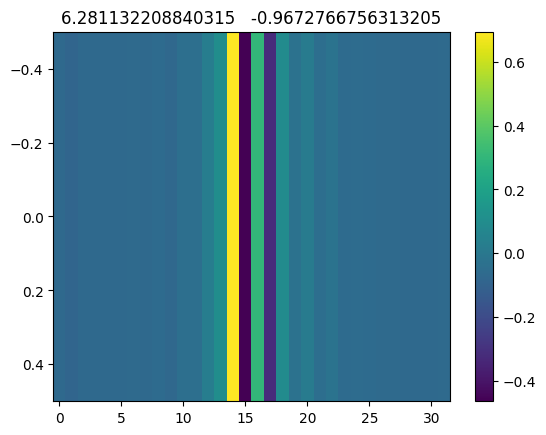

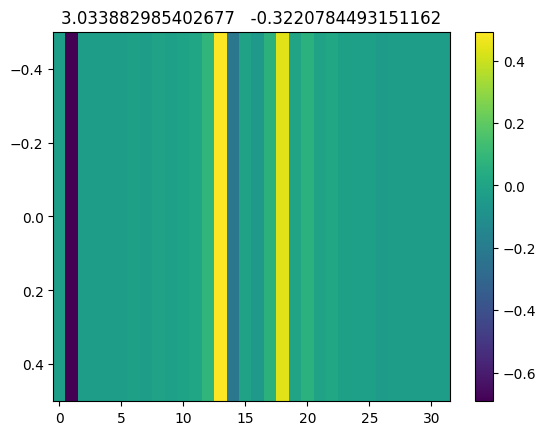

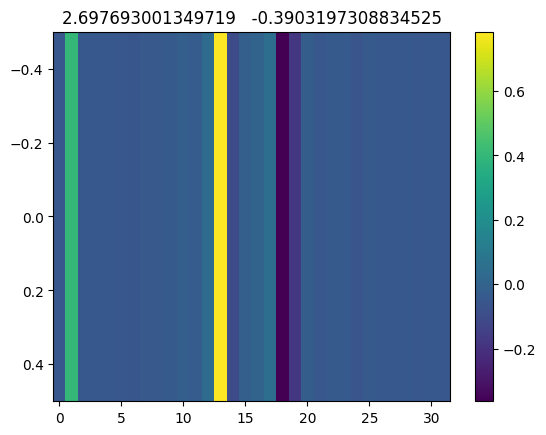

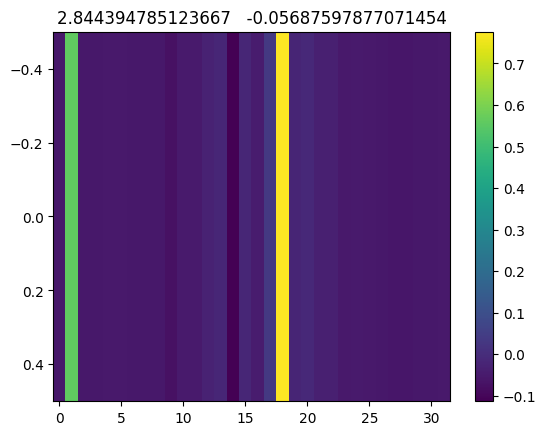

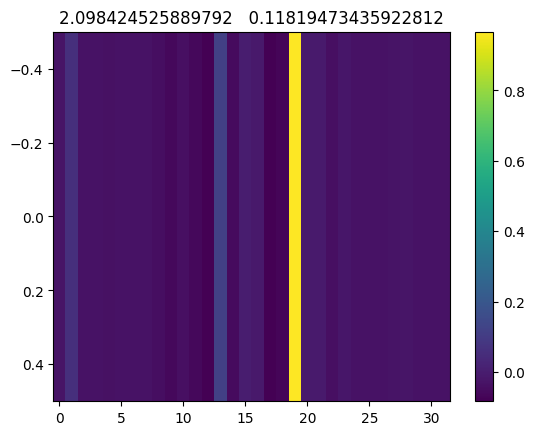

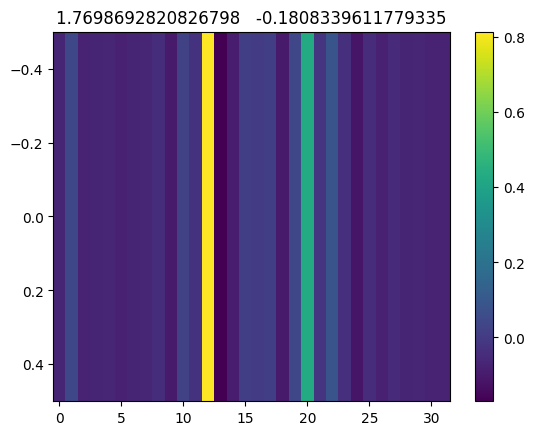

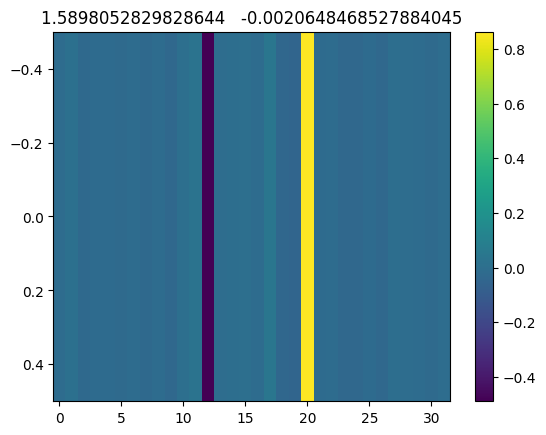

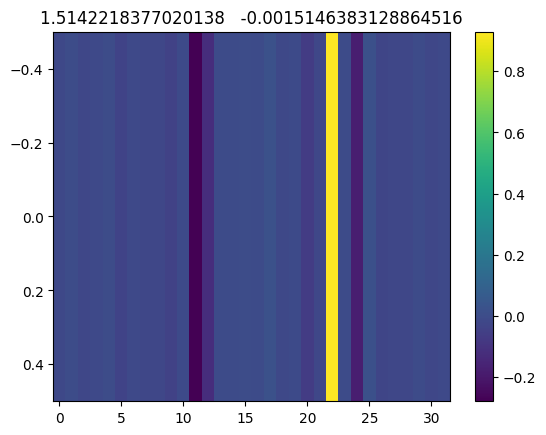

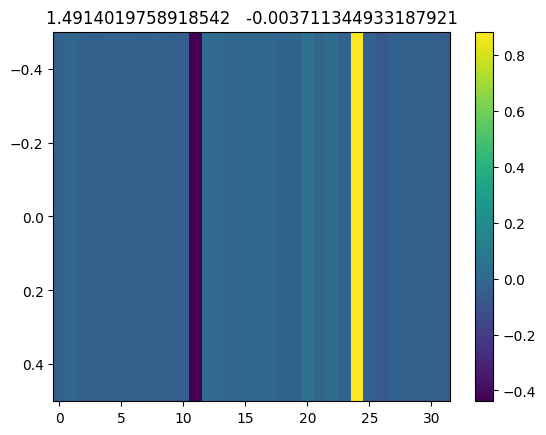

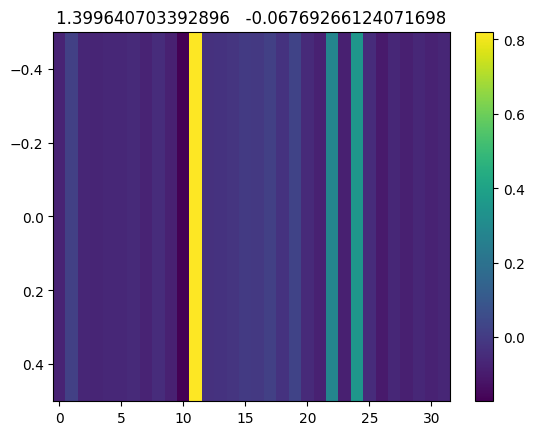

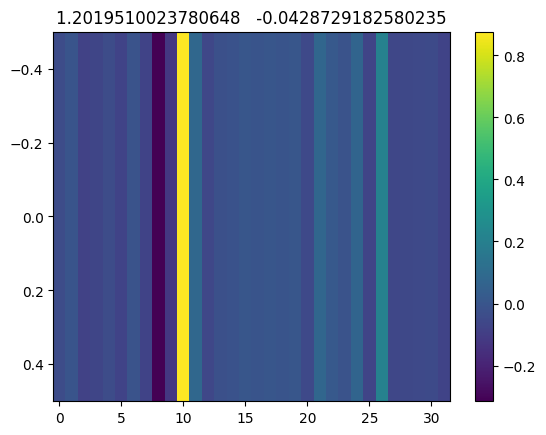

In [47]:
print( cp.sqrt(cp.nanmean( (data[sens_id]-cp.tensordot(weights,components,axes=([1], [0])))**2)))
print( cp.sqrt(cp.nanmean( (data[sens_id]-cp.tensordot(weights,components,axes=([1], [0])))**2)))
for ii in range(len(Scomponents)):
    plt.figure()
    plt.imshow(Scomponents[ii][0,...].get(), aspect='auto')
    plt.colorbar()
    # plt.figurez()
    # plt.imshow(cp.log(cp.nanmean(data[sens_id],0)).get())
    # plt.colorbar()
    # plt.figure()
    # plt.imshow(cp.log(-components[ii,...]).get(), aspect='auto')
    # plt.colorbar()
    # plt.figure()
    # plt.imshow(cp.mean(cp.isnan(data[sens_id]),0).get())
    # plt.colorbar()
    # plt.figure()
    #plt.imshow(cp.log(-components[ii,...]/cp.nanmean(data[sens_id],0)).get(), aspect='auto')
    #plt.colorbar()
    plt.title(str(kgs.rms(Sweights[ii]).get())+'   '+str(cp.sum(Scomponents[ii]).get()))

155.7448238615181 162.1222369492468
-254.61363653558178 2.1937355527042772


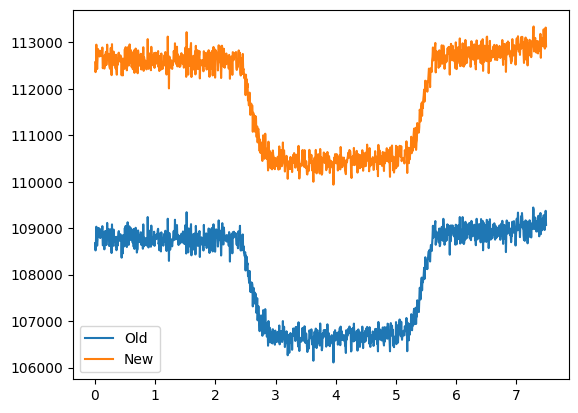

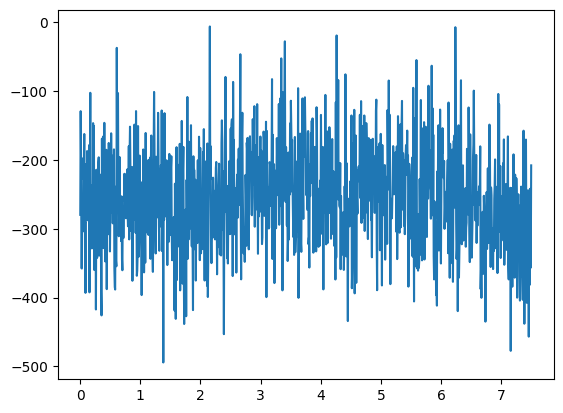

In [61]:
for ii in range(1):
    import ariel_numerics
    import importlib
    importlib.reload(ariel_numerics)
    design_matrix = copy.deepcopy(np.stack([cp.ones(np.prod(shp))]+[x.flatten() for x in Scomponents[:4]]).T)

    d = copy.deepcopy(train_data[ii])
    dd = copy.deepcopy(d)
    d.load_to_step(0, ariel_load.default_loaders())
    d.load_to_step(2, ariel_load.default_loaders())
    dat = d.transits[0].data[sens_id].data[:,:,i_wavelength].reshape(-1,np.prod(shp))
    times = d.transits[0].data[sens_id].times

    #dat[:,16]=cp.nan

    valid = ~cp.isnan(cp.mean(dat,0)).flatten()
   # print(np.sum(~valid))
    design_matrix[:,0]/=np.sum(design_matrix[:,0][valid])


    Nbin = 5
    dat = ariel_load.bin_first_axis(dat,Nbin)
    times = ariel_load.bin_first_axis(times,Nbin)

    loaders = ariel_load.default_loaders()
    loaders[1].apply_time_binning.time_binning = Nbin
    #loaders[1].apply_full_sensor_corrections.remove_background_based_on_rows = False
    dd.load_to_step(0, loaders)
    dd.load_to_step(5, loaders)

    noise_est = cp.ones(dat.shape[1])
    for ii in range(dat.shape[1]):
       noise_est[ii] = ariel_numerics.estimate_noise_cp(dat[:,ii])
    noise_est[cp.isnan(noise_est)]=cp.nanmean(noise_est)


    #dat = times[:,None]*Scomponents[0].flatten()[None,:]
    #for ii in range(dat.shape[1]):
    #    dat[:,ii] += noise_est[ii]*cp.random.default_rng(ii).standard_normal(dat.shape[0])
    #print(cp.min(noise_est))

    cov = ariel_numerics.estimate_noise_cov_cp(dat, window_size=10)
    #cov[cp.isnan(cov)]=
    #cov = cp.diag(noise_est**2)
    # plt.figure()
    # plt.imshow(dat.get(), aspect='auto')
    #plt.figure();plt.imshow(cov.get());plt.colorbar()


    # plt.figure()
    # plt.imshow((noise_est/cp.sqrt(cp.mean(dat,0))).get().reshape(shp))
    # plt.clim([0,30])
    # plt.colorbar()
    # plt.figure()
    # plt.imshow((noise_est/cp.sqrt(a)).get().reshape(shp))
    # plt.clim([0,30])
    # plt.colorbar()
    # plt.figure()
    # plt.imshow((cp.mean(dat,0)).get().reshape(shp))
    # #plt.clim([-2,2])
    # plt.colorbar()
    # plt.figure()
    # plt.imshow((a).get().reshape(shp))
    # #plt.clim([-2,2])
    # plt.colorbar()
    # plt.figure()
    # plt.imshow((a).get().reshape(shp))
    # plt.colorbar()

    def expand_pinv(A_pinv_w, mask, N):
        A_pinv_full = cp.nan*cp.zeros((A_pinv_w.shape[0], N), dtype=A_pinv_w.dtype)
        A_pinv_full[:, mask] = A_pinv_w
        return A_pinv_full

    #cov = cp.diag(noise_est**2)
    D = design_matrix[:,0:3]
   # print(dat.T.shape, D.shape, cov.shape)
    #print('x', cp.sum(cp.isnan(dat)), cp.sum(cp.isnan(D)), cp.sum(cp.isnan(cov)))
    coeffs, A_pinv_w, mask = ariel_numerics.lstsq_nanrows_gls_with_pinv(dat.T, D, cov)
    A_pinv_w = expand_pinv(A_pinv_w, mask, np.prod(shp))
   # print(coeffs.shape)
    weight =cp.sum(D,0)[None,:]
    weight[0,0]=0
    pred_new = weight@coeffs
    #print(cp.mean(D,0)/cp.mean(abs(D),0))
    pred_new = pred_new[0,:]
   # print(pred_new.shape)

    dat_residual = (dat.T - D@coeffs).T
    #print('residual mean', cp.nanmean(dat_residual))

    #coeffs, A_pinv_w, mask = ariel_numerics.lstsq_nanrows_normal_eq_with_pinv_sigma(dat.T, design_matrix[:,0:4], noise_est)
    #A_pinv_w = expand_pinv(A_pinv_w, mask, np.prod(shp))



    # plt.figure()
    # plt.imshow((A_pinv_w[0,:]).get().reshape(shp))
    # plt.colorbar()

    # plt.figure()
    # plt.imshow(cp.mean(dat - (coeffs[0:1,None]*design_matrix[:,0:1])[0,...].T ,0).get().reshape(shp))
    # plt.colorbar()

    #coeffs2 = ariel_numerics.lstsq_nanrows_normal_eq(dat.T, design_matrix[:,0:1])
    #print(coeffs.shape)

    def reshape(x):
        return x#(x-np.mean(x))/np.std(x)

    def plot_reshaped(x):
        plt.plot(times.get()/3600,reshape(x).get())

    pred_old = dd.transits[0].data[sens_id].data[:,i_wavelength]
    print( ariel_numerics.estimate_noise_cp(reshape(pred_old)),  ariel_numerics.estimate_noise_cp(reshape(pred_new)))
    
    #pred_new = cp.nansum(dat,1)
    #print( ariel_numerics.estimate_noise_cp(pred_old, window_size=10),  ariel_numerics.estimate_noise_cp(pred_new, window_size=10))
    vec = cp.ones(np.prod(shp))#/cp.sum(valid)
   #print(np.sqrt(vec[valid][None,:]@cov[valid][:,valid]@vec[valid][:,None]), np.sqrt(A_pinv_w[1,:][valid][None,:]@cov[valid][:,valid]@A_pinv_w[1,:][valid][:,None]))
    #print(np.sum(vec[valid]*design_matrix[:,0][valid]), np.sum(A_pinv_w[1,:][valid]*design_matrix[:,0][valid]))

    # plt.figure()
    # plot_reshaped(pred_new)
    # plot_reshaped(coeffs2[0,:])

    plt.figure()
    #plot_reshaped(coeffs2[0,:])
    plot_reshaped(pred_old)
    plot_reshaped(pred_new)
    plt.legend(('Old', 'New'))
    #plot_reshaped(Sweights[0])
    #plot_reshaped(pred_new)
    #plot_reshaped(cp.nanmean(dat,1))

   # plt.figure()
    #plot_reshaped(coeffs2[0,:])
    #plot_reshaped(pred_new)
    #plot_reshaped(Sweights[0])
    # plot_reshaped(pred_new)
    # plot_reshaped(pred_old)
    # plt.legend(('New', 'Old'))
    # plt.figure()
    # #plot_reshaped(coeffs2[0,:])
    # #plot_reshaped(pred_new)
    # #plot_reshaped(Sweights[0])
    # plot_reshaped(pred_old)
    # plot_reshaped(pred_new)
    # plt.legend(('Old', 'New'))
    # plt.figure()
    # plot_reshaped(pred_old/pred_new)
    # plt.figure()
    # plot_reshaped(pred_old/cp.nansum(dat,1))
    # #plt.figure()
    #plot_reshaped(pred_old-pred_new)
    #plt.plot(times.get()/3600, pred_new.get())
    #plt.plot(times.get()/3600, cp.nanmean(dat,1).get())
    # plt.figure()
    # #plot_reshaped(coeffs2[0,:])
    # #plot_reshaped(pred_new)
    # #plot_reshaped(Sweights[0])
    # plot_reshaped(coeffs[1,:])
    # plot_reshaped(coeffs[2,:])
    # plot_reshaped(coeffs[3,:])
    #plot_reshaped(coeffs[4,:])

    plt.figure()
    # #plot_reshaped(coeffs2[0,:])
    # #plot_reshaped(pred_new)
    # #plot_reshaped(Sweights[0])
    print(cp.mean(coeffs[0,:]), cp.std(coeffs[0,:])/cp.sqrt(coeffs.shape[1]))
    for ii in [0]:
        plot_reshaped(coeffs[ii,:])
    plt.pause(0.001)
    


In [7]:
ii=2
n_avg=100
n_bin = 1
time_series = pred_old#np.nansum(mats[ii],axis=(1,2))
binned = 0*time_series[::n_bin]
for ii in range(n_bin):
    binned+=time_series[ii::n_bin]
time_series=binned
time_series = time_series[(n_avg-1)//2:-(n_avg-1)//2] - kgs.moving_average(time_series,n_avg)
import matplotlib.pyplot as plt
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(time_series, lags=40)
plt.show()

ImportError: cannot import name '_lazywhere' from 'scipy._lib._util' (/home/jcottaar/miniconda3/envs/xlab/lib/python3.11/site-packages/scipy/_lib/_util.py)

In [ ]:
import ariel_numerics
import importlib
importlib.reload(ariel_numerics)
design_matrix = copy.deepcopy(np.stack([cp.ones(np.prod(shp))]+[x.flatten() for x in Scomponents[:4]]).T)

Nbins = np.arange(10,100,10)
cov_res = []
d = train_data[0]
d.load_to_step(2, ariel_load.default_loaders())
datt = d.transits[0].data[sens_id].data.reshape(-1,np.prod(shp))
for Nbin in Nbins:

    

    dat = ariel_load.bin_first_axis(datt,50)
  #  times = ariel_load.bin_first_axis(times,Nbin)

    #loaders = ariel_load.default_loaders()
    #loaders[0].apply_time_binning.time_binning = Nbin
    #dd.load_to_step(5, loaders)

    cov = ariel_numerics.estimate_noise_cov_cp(dat, window_size=Nbin)
    # noise_est = cp.zeros(dat.shape[1])
    # for ii in [496]:#range(len(noise_est)):
    #     noise_est[ii] = ariel_numerics.estimate_noise_cp(dat[:,ii])*np.sqrt(Nbin)
    # cov = cp.diag(noise_est**2)
    cov[cp.isnan(cov)]=0
    cov_res.append(cov)
    plt.figure()
    plt.imshow(cov[:,528].reshape(shp).get())
    plt.colorbar()

In [ ]:
plt.figure();plt.grid(True)
ind = cp.argmax(cp.diag(cov_res[-1]))
print(ind)
plt.plot(Nbins, [cp.sqrt(cp.diag(c)[ind]).get() for c in cov_res])
plt.figure();plt.grid(True)
ind = cp.argmax(cp.diag(cov_res[-1]))
plt.plot(Nbins, [cp.sqrt(cp.sum(cp.diag(c))).get() for c in cov_res])

In [ ]:
print([cp.sqrt(cp.diag(c)[ind]).get() for c in cov_res])

In [ ]:
valid.shape

In [ ]:
importlib.reload(ariel_numerics)
dat_base = ariel_load.bin_first_axis(dat,10)
dat_limited= dat_base
#dat_limited = dat_base[:,cp.sum(cp.isnan(dat_base),0)==0]
#dat_limited = dat_limited[:,cp.mean(dat_limited,0)>1000]
#dat_limited = cp.random.default_rng(seed=0).standard_normal((20000,50))+cp.arange(20000)[:,None]
cov = dat_limited.T@dat_limited
print(cp.sum(cp.isnan(cov)))
plt.figure()
plt.imshow(cov.get())
plt.colorbar()

print(dat_limited.shape)
cov = ariel_numerics.estimate_noise_cov_cp(dat_limited)
print(cp.sum(cp.isnan(cov)))
plt.figure()
plt.imshow(cov.get())
plt.colorbar()

In [ ]:
def show_cov(dat):
    flat = dat.reshape((dat.shape[0],-1))
    flat = flat[:,~cp.any(cp.isnan(flat),0)]
    print(flat.shape)
    print(cp.cov(flat.T).shape)
    plt.figure()
    plt.imshow(cp.cov(flat.T).get())
    plt.colorbar()
dat = copy.deepcopy(data[sens_id])
show_cov(dat)
SS = []
for ii in range(20):
    weights,components,S = nan_pca(dat, 1, tol=1e-5, verbose=False)
    dat = dat - cp.tensordot(weights,components,axes=([1], [0]))
    show_cov(dat)
    plt.figure()
    plt.imshow(-components[0,...].get(), aspect='auto')
    plt.colorbar()
    plt.title(str(kgs.rms(weights[:,0]).get())+'   '+str(cp.median(components[0,...]).get()))
    plt.pause(0.001)
    SS.append(kgs.rms(weights[:,0]).get())
plt.figure()
plt.semilogy(SS)

In [ ]:
# n_samples = 1000
# n_features = 100
# n_comp = 1
# noise_fac = 1
# nan_fac=0.9
# C_test = cp.random.default_rng(seed=0).standard_normal(size=(n_comp,n_features))
# W_test = cp.random.default_rng(seed=0).standard_normal(size=(n_samples,n_comp))
# data = W_test@C_test
# data += noise_fac*cp.random.default_rng(seed=0).standard_normal(size=data.shape)
# data[cp.random.default_rng(seed=0).uniform(size=data.shape)<nan_fac] = cp.nan
# weights,components,S=nan_pca(data,1,verbose=True)
# #kgs.rms(components/kgs.rms(components)-C_test/kgs.rms(C_test))
# cp.sqrt(cp.nanmean( (data)**2 )), cp.sqrt(cp.nanmean( (data-weights@components)**2 )), cp.sqrt(cp.nanmean( (data-W_test@C_test)**2 ))

In [ ]:
kgs.rms(C_test)